# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset (CIFAR), and then work our way up to TinyImageNet! This homework originally written by Daniel Gordon with very minor modifications.

# Initial Setup

This will authenticate Colab to connect to your google drive account. This way you have space to store the datasets and won't have to redownload them every time. You'll also have stable storage to save your best performing networks.

In [2]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
'My Drive'  'Shared drives'


Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.

Have a look at [pt_util](https://gist.github.com/pjreddie/e531394d779af2da9201096af0dba78a). We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.

In [6]:
import os

BASE_PATH = '/gdrive/My Drive/colab_files/hw1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !rm homework2.tar
!pwd
!ls
os.chdir('/content')

/content
sample_data
/gdrive/My Drive/colab_files/hw1
cifar  pt_util.py  __pycache__	tiny_imagenet


# CIFAR

## Part 1: Getting the Dataset
Normally, we'd want to download our dataset first. Since PyTorch hosts the CIFAR dataset, we can load it using their helper function later.

But, we'll change DATA_PATH to an empty directory to download the dataset to.

In [7]:
DATA_PATH = BASE_PATH + 'cifar/'

## Part 2: Defining the Network
Just like with MNIST last homework we need to define our network architecture. This time we will be using convolutional layers and maxpooling to extract features from our images before we feed those features into our final classifier.

Check out the documentation for [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

    nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0,...)

So the first parameter is the number of channels in the input. Second is the number of filters we'll use (AKA number of channels in the output). Third is kernel size. Next is stride and padding which are optional and have default values.

In [32]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [43]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(1024, 10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        print(x.size())
        x = torch.flatten(x, 1)
        print(x.size())
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


In [44]:
# summary
net = CifarNet()
summary(net.cuda(), (3, 32, 32))

torch.Size([2, 64, 4, 4])
torch.Size([2, 1024])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
            Conv2d-2             [-1, 32, 8, 8]           4,640
            Conv2d-3             [-1, 64, 4, 4]          18,496
            Linear-4                   [-1, 10]          10,250
Total params: 33,834
Trainable params: 33,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.13
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

## Part 3 and 4: Loading Data and Dataset Augmentation

In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

Extracting /gdrive/My Drive/colab_files/hw1/cifar/cifar-10-python.tar.gz to /gdrive/My Drive/colab_files/hw1/cifar/
Files already downloaded and verified


In [ ]:
# My Network

class MyNet(nn.Module):
    def __init__(self, num_classes: int = 10, net_id: int = 1):
        super(MyNet, self).__init__()
        # NETWORK 1
        self.net1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.classifier1 = nn.Linear(64 * 4 * 4, num_classes)

        # NETWORK 2
        self.net2 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(2048, 256),
            nn.Linear(256, 128),
            nn.Linear(128, num_classes),
        )

        self.net_id = net_id
        self.nets = {1:self.net1,2:self.net2}
        self.classifiers = {1:self.classifier1,2:self.classifier2}
        self.accuracy = None
        print("Using Network",self.net_id)

    def forward(self, x):
        x = self.nets[self.net_id](x)
        x = torch.flatten(x, 1)
        x = self.classifiers[self.net_id](x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

summary(MyNet(net_id=2).cuda(), (3, 32, 32))

Using Network 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
           Linear-11                  [-1, 128]          32,896
           Linear-12                   [-1, 10]           1,290
Total params: 651,978
Trainable params: 651,978
Non-trainable params: 0
---------------

## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 

Try different network architectures and experiment with hyperparameters. You'll answer the questions at the bottom of the file based on these experiments.


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.

Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to increment your experiment version number so you start over with your training and log files.

In [ ]:
# # Play around with these constants, you may find a better setting.
# BATCH_SIZE = 128
# TEST_BATCH_SIZE = 64
# EPOCHS = 30
# LEARNING_RATE = 0.01
# MOMENTUM = 0.9
# USE_CUDA = True
# SEED = 0
# PRINT_INTERVAL = 100
# WEIGHT_DECAY = 0.005

# EXPERIMENT_VERSION = "201104_007" # increment this to start a new experiment
# LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# # Now the actual training code
# use_cuda = USE_CUDA and torch.cuda.is_available()

# #torch.manual_seed(SEED)

# device = torch.device("cuda" if use_cuda else "cpu")
# print('Using device', device)
# import multiprocessing
# print('num cpus:', multiprocessing.cpu_count())

# kwargs = {'num_workers': multiprocessing.cpu_count(),
#           'pin_memory': True} if use_cuda else {}

# class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
#                                            shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
#                                           shuffle=False, **kwargs)

# # model = CifarNet().to(device)
# model = MyNet(net_id=2).to(device)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# start_epoch = model.load_last_model(LOG_PATH)

# train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
# test_loss, test_accuracy = test(model, device, test_loader)

# test_losses.append((start_epoch, test_loss))
# test_accuracies.append((start_epoch, test_accuracy))

# try:
#     for epoch in range(start_epoch, EPOCHS + 1):
#         train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
#         test_loss, test_accuracy = test(model, device, test_loader)
#         train_losses.append((epoch, train_loss))
#         test_losses.append((epoch, test_loss))
#         test_accuracies.append((epoch, test_accuracy))
#         pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
#         model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


# except KeyboardInterrupt as ke:
#     print('Interrupted')
# except:
#     import traceback
#     traceback.print_exc()
# finally:
#     model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
#     ep, val = zip(*train_losses)
#     pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
#     ep, val = zip(*test_losses)
#     pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
#     ep, val = zip(*test_accuracies)
#     pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')


Using device cuda
num cpus: 2
TRYING:  201104_ARCID1_LRS0_MOM0.9_WD0.01
Using Network 1

Test set: Average loss: 2.3040, Accuracy: 977/10000 (10%)

Current Learning Rate:  0.01
Thu Nov  5 03:19:38 2020 Train Epoch: 0 [0/50000 (0%)]	Loss: 2.303993
Thu Nov  5 03:19:43 2020 Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.239323

Test set: Average loss: 1.9927, Accuracy: 2920/10000 (29%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/201104_ARCID1_LRS0_MOM0.9_WD0.01/000.pt

Thu Nov  5 03:19:52 2020 Train Epoch: 1 [0/50000 (0%)]	Loss: 2.086724
Thu Nov  5 03:19:57 2020 Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.929587

Test set: Average loss: 1.8515, Accuracy: 3536/10000 (35%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/201104_ARCID1_LRS0_MOM0.9_WD0.01/001.pt

Thu Nov  5 03:20:06 2020 Train Epoch: 2 [0/50000 (0%)]	Loss: 1.872096
Thu Nov  5 03:20:11 2020 Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.782978

Test set: Average loss: 1.7262, Accuracy: 3939/10000 (39%)

Saved /gdrive/My Drive/

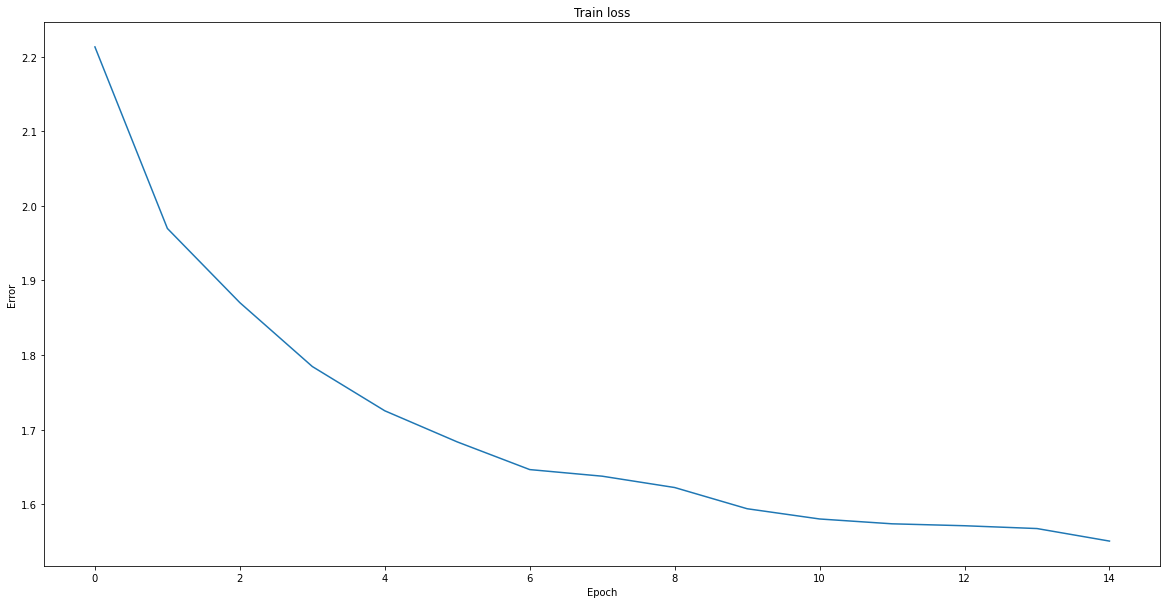

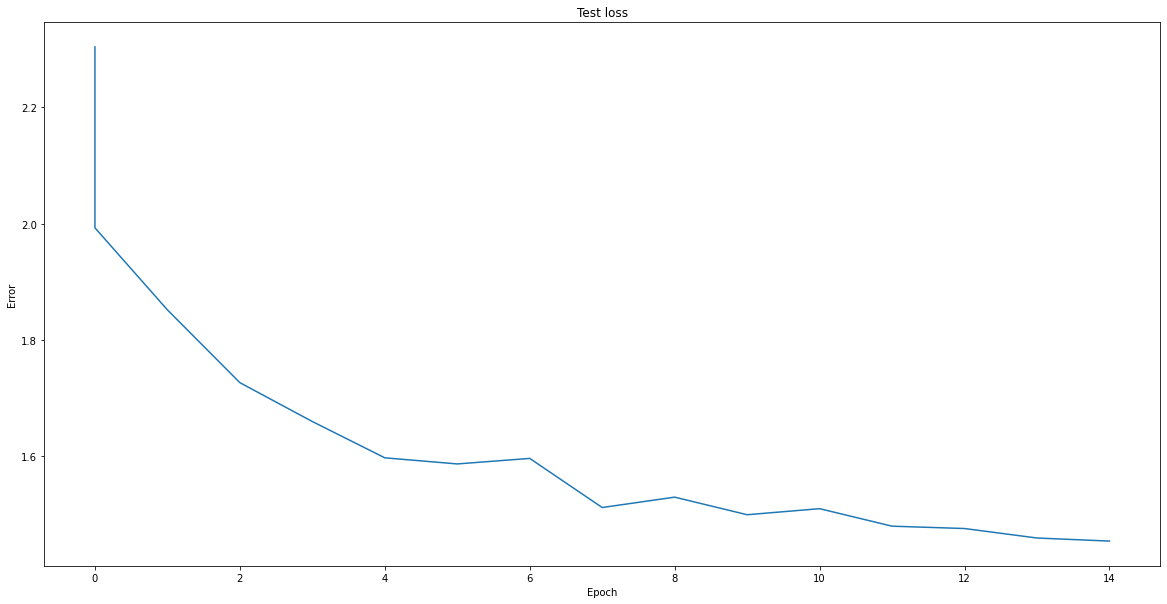

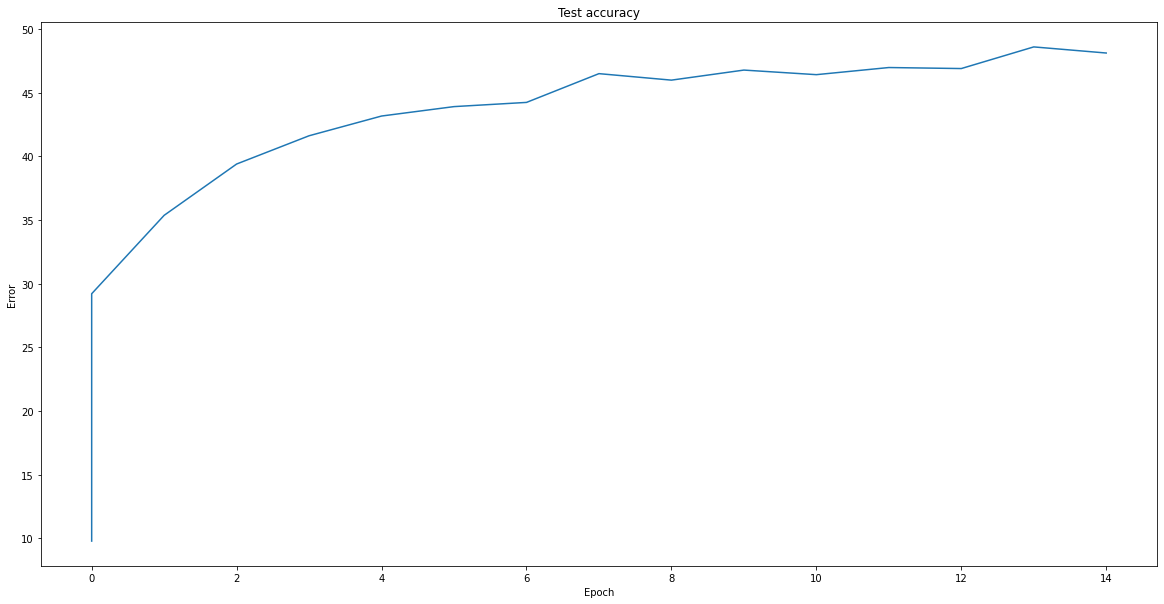

TRYING:  201104_ARCID1_LRS0_MOM0.9_WD0.005
Using Network 1

Test set: Average loss: 2.3032, Accuracy: 987/10000 (10%)

Current Learning Rate:  0.01
Thu Nov  5 03:23:21 2020 Train Epoch: 0 [0/50000 (0%)]	Loss: 2.305625
Thu Nov  5 03:23:26 2020 Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.268876
Interrupted
Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/201104_ARCID1_LRS0_MOM0.9_WD0.005/000.pt



ValueError: ignored

In [ ]:
# My Loop
# Play around with these constants, you may find a better setting.
# BATCH_SIZE = 128
# TEST_BATCH_SIZE = 64
# EPOCHS = 30
# LEARNING_RATE = 0.01
# MOMENTUM = 0.9
# USE_CUDA = True
# SEED = 0
# PRINT_INTERVAL = 100
# WEIGHT_DECAY = 0.005

BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 40
# LEARNING_RATE_SCHEDULES = [(0.01 for e in range(EPOCHS)), (0.1 / (10**(e//(EPOCHS/3)+1)) for e in range(EPOCHS))]
# LEARNING_RATE_SCHEDULES = [(0.1 / (10**(e//(EPOCHS/3)+1)) for e in range(EPOCHS))]
LEARNING_RATE = 0.01
MOMENTUMS = [0.9, 0.8]

WEIGHT_DECAYS = [0.01, 0.005]

USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())
kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

SEED = 0
PRINT_INTERVAL = 100

# load data
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                          shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)
BEST_MODEL = ""
WORST_MODEL = ""
BEST_LOSS = 1e6
WORST_LOSS = -1E6
for ARCHITECTURE_ID in range(1,3):
  for MOMENTUM in MOMENTUMS:
    for WEIGHT_DECAY in WEIGHT_DECAYS:
      EXPERIMENT_VERSION = "201104_ARCID{}_LRS{}_MOM{}_WD{}".format(ARCHITECTURE_ID, 0, MOMENTUM, WEIGHT_DECAY) # increment this to start a new experiment
      print("TRYING: ",EXPERIMENT_VERSION)
      LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'


      model = MyNet(net_id=ARCHITECTURE_ID).to(device)
      
      start_epoch = model.load_last_model(LOG_PATH)

      train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
      test_loss, test_accuracy = test(model, device, test_loader)

      test_losses.append((start_epoch, test_loss))
      test_accuracies.append((start_epoch, test_accuracy))


      # LEARNING_RATE = next(LEARNING_RATE_SCHEDULE)
      print("Current Learning Rate: ",LEARNING_RATE)
      optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


      try:
          for epoch in range(start_epoch, EPOCHS + 1):                
              train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
              test_loss, test_accuracy = test(model, device, test_loader)
              train_losses.append((epoch, train_loss))
              test_losses.append((epoch, test_loss))
              test_accuracies.append((epoch, test_accuracy))
              pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
              model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
          if(test_loss < BEST_LOSS):
            BEST_LOSS = test_loss
            BEST_MODEL = EXPERIMENT_VERSION
          if (test_loss > WORST_LOSS):
            WORST_LOSS = test_loss
            WORST_MODEL = EXPERIMENT_VERSION


      except KeyboardInterrupt as ke:
          print('Interrupted')
      except:
          import traceback
          traceback.print_exc()
      finally:
          model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
          ep, val = zip(*train_losses)
          pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
          ep, val = zip(*test_losses)
          pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
          ep, val = zip(*test_accuracies)
          pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')




In [ ]:
print(BEST_MODEL)

##CIFAR Questions

1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.

My best network was very similar to the stock network, but I added additional fully connected layers to help with feature extraction. I tested across a variety of momentums, weight decays and learning rates.
Constant Learning Rate: 0.01
Epochs = 20
Batch Size = 256

The HW is already 2 days late so I did not have time to play around with data augmentation too much or batch size modification. Intuition says that batch size shouldn't affect performance too much since we go through all the samples anyway. Data augmentation should help with generalization and prevent overfitting. The best way to help with overfitting is to have more data. Data augmentation is a pseudo-increase in the amount of data, but it should still do the trick.

2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.

One thing that destroyed my performance was trying to institute a naiive learning rate schedule. The thought was to get more fine grained descent directions as the process went on into higher epochs, but the loss never converged enough to make a difference in the 30 epochs I would run. 

3. Why do you think the best one worked well and the worst one worked poorly.

Any network I ran for longer tended to do better. I think instituting some kind of threshold criteria of loss delta would help to not cut off the training before the network has fully extracted as much information as possible. 

I should have run 50 epochs and then decreased the learning rate, or better yet have the learning rate jump down then the delta in loss is smaller than some threshold. 

My second network architecture worked better because it had larger and more fully connected layers. I think this allowed it extract the features in finer detail while also not forcing neurons to generalize too much.



---
# TinyImageNet

## Part 1: Upload the Dataset
Change the DATA_PATH to the path of the TinyImageNet dataset we downloaded earlier.

In [8]:
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

## Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try:

- Maxpooling
- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

To define your network you'll have to figure out more about the Tiny ImageNet dataset. Specifically, what size are the images you'll be processing? How big is your label space? You can find this out by examining samples of your data.

In [33]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [49]:
class TinyImagenetNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(TinyImagenetNet, self).__init__()

        self.conv64 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv3x3_64 = nn.Conv2d(64,64,3,stride=1,padding=1)
        self.conv1x1_64 = nn.Conv2d(64, 64, 1, stride=1, padding=0)
        
        self.conv128 = nn.Conv2d(64,128,3,stride=1,padding=1)
        self.conv3x3_128 = nn.Conv2d(128,128,3,stride=1,padding=1)
        self.conv1x1_128 = nn.Conv2d(128, 128, 1, stride=1, padding=0)

        self.conv256 = nn.Conv2d(128,256,3,stride=1,padding=1)
        self.conv3x3_256 = nn.Conv2d(256,256,3,stride=1,padding=1)
        self.conv1x1_256 = nn.Conv2d(256, 256, 1, stride=1, padding=0)

        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(256*16*16,200)
        self.accuracy = None

    def forward(self, x):
        
        x = F.relu(self.conv64(x))
        res = x
        x = F.relu(self.conv3x3_64(x))
        x = F.relu(self.conv1x1_64(x))
        x = F.relu(self.conv3x3_64(x))
        x += res
        x = self.mp(x)
        
        x = F.relu(self.conv128(x))
        res = x
        x = F.relu(self.conv3x3_128(x))
        x = F.relu(self.conv1x1_128(x))
        x = F.relu(self.conv3x3_128(x))
        x += res
        x = self.mp(x)

        x = F.relu(self.conv256(x))
        res = x
        x = F.relu(self.conv3x3_256(x))
        x = F.relu(self.conv1x1_256(x))
        x = F.relu(self.conv3x3_256(x))
        x += res
        
        x=x.view(x.size(0),-1)
        x = self.fc(x)

        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

net = TinyImagenetNet()
summary(net.cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
            Conv2d-2           [-1, 64, 64, 64]          36,928
            Conv2d-3           [-1, 64, 64, 64]           4,160
            Conv2d-4           [-1, 64, 64, 64]          36,928
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
            Conv2d-7          [-1, 128, 32, 32]         147,584
            Conv2d-8          [-1, 128, 32, 32]          16,512
            Conv2d-9          [-1, 128, 32, 32]         147,584
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
           Conv2d-12          [-1, 256, 16, 16]         590,080
           Conv2d-13          [-1, 256, 16, 16]          65,792
           Conv2d-14          [-1, 256,

This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [50]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy


## Part 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be accessed a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Hints:
1. HDF5s don't support concurrent accesses.
2. If you don't close the HDF5 file, you will still have problems with concurrency.
3. One way to deal with concurrent accesses is to copy the entirety of the data into each process separately. Then each process accesses its own copy of the data. https://stackoverflow.com/questions/40449659/does-h5py-read-the-whole-file-into-memory
4. Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [51]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        self.transform = transform
        self.h5_file = h5py.File(h5_file, 'r')
        self.images = self.h5_file['images'][:]
        self.labels = torch.LongTensor(self.h5_file['labels'][:])
        
    def __len__(self):
        return self.labels.shape[0]
      
    def __getitem__(self, idx):
        data = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            data = self.transform(data)
        return (data, label)


## Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [52]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    ])
print(DATA_PATH)
data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
print(len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)
print(len(data_test))


/gdrive/My Drive/colab_files/hw1/tiny_imagenet/
100000
8000


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


Using device cuda
num cpus: 2

Test set: Average loss: 5.2986, Accuracy: 35/8000 (0%)



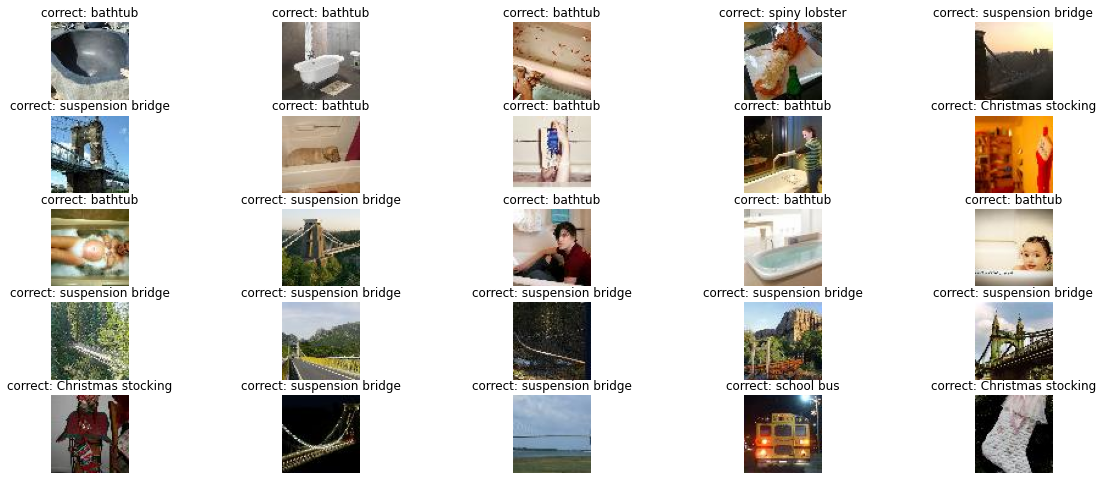

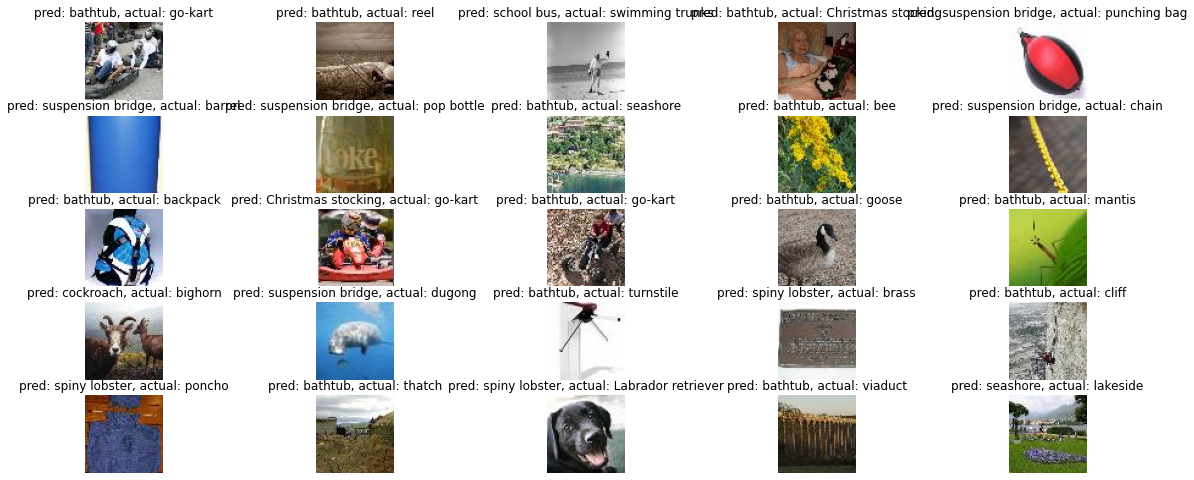

Thu Nov  5 04:50:34 2020 Train Epoch: 0 [0/100000 (0%)]	Loss: 5.299488
Thu Nov  5 04:51:23 2020 Train Epoch: 0 [25600/100000 (26%)]	Loss: 5.151578
Thu Nov  5 04:52:13 2020 Train Epoch: 0 [51200/100000 (51%)]	Loss: 4.960905
Thu Nov  5 04:53:03 2020 Train Epoch: 0 [76800/100000 (77%)]	Loss: 4.686083

Test set: Average loss: 4.5136, Accuracy: 734/8000 (9%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/0.1/000.pt

Thu Nov  5 04:53:54 2020 Train Epoch: 1 [0/100000 (0%)]	Loss: 4.472619
Thu Nov  5 04:54:44 2020 Train Epoch: 1 [25600/100000 (26%)]	Loss: 4.336434
Thu Nov  5 04:55:34 2020 Train Epoch: 1 [51200/100000 (51%)]	Loss: 4.143987
Thu Nov  5 04:56:24 2020 Train Epoch: 1 [76800/100000 (77%)]	Loss: 4.260929

Test set: Average loss: 4.1142, Accuracy: 1154/8000 (14%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/0.1/001.pt

Thu Nov  5 04:57:16 2020 Train Epoch: 2 [0/100000 (0%)]	Loss: 4.099956
Thu Nov  5 04:58:06 2020 Train Epoch: 2 [25600/100000 (26%)]	Loss: 4.1198

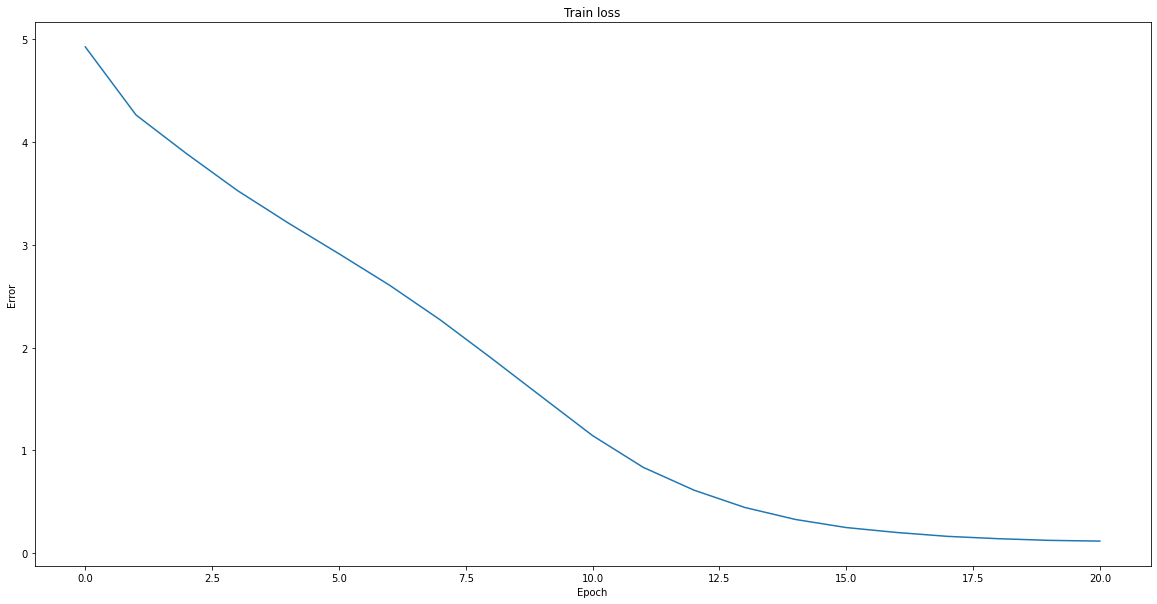

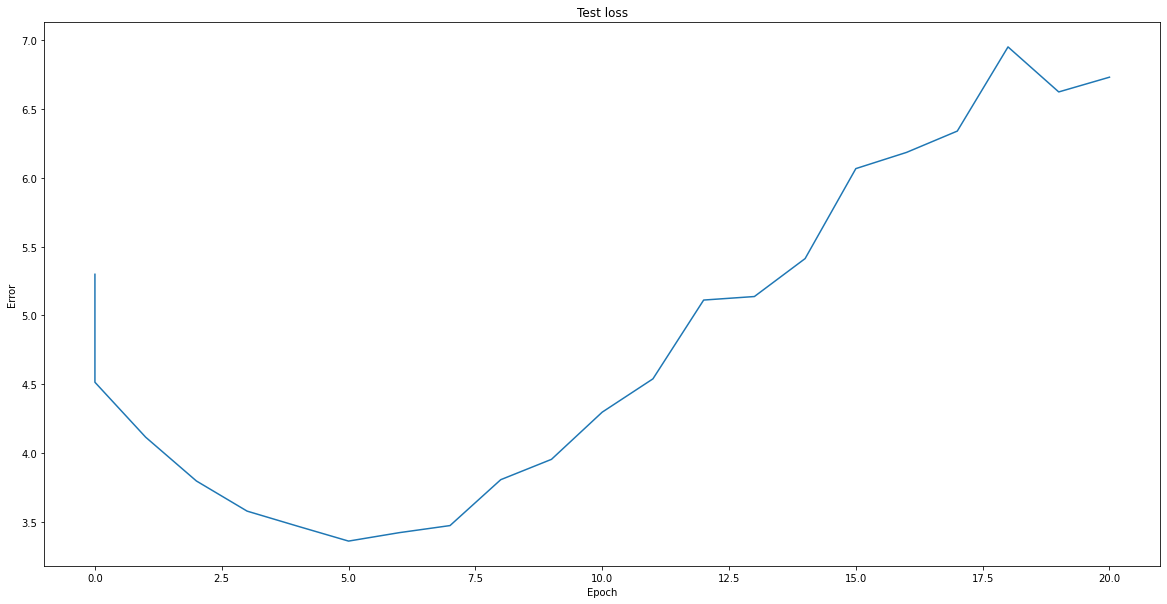

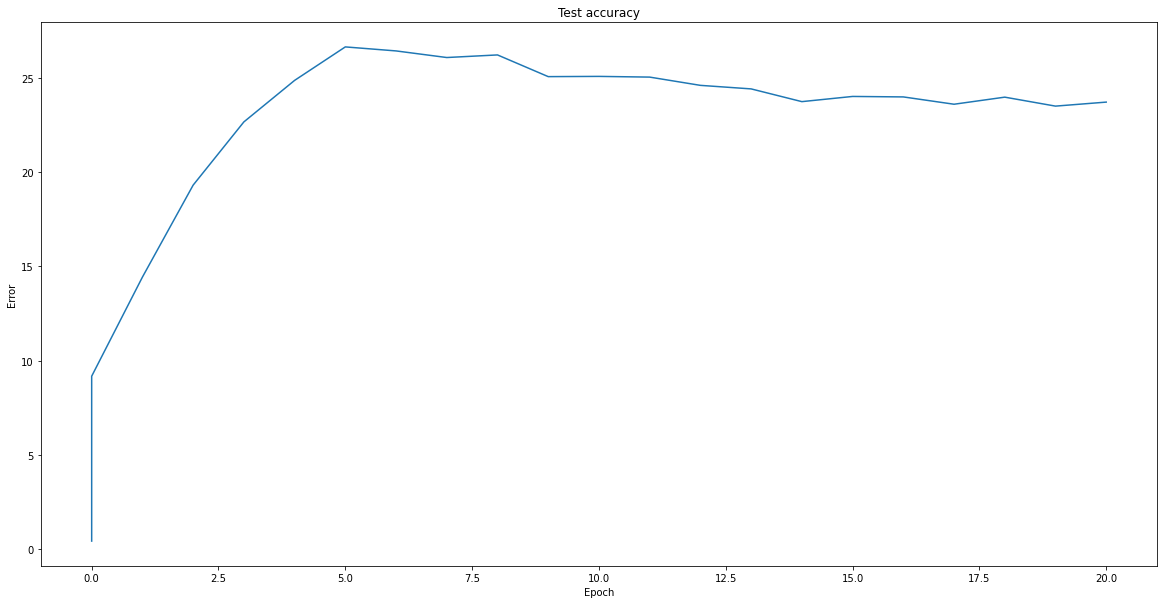

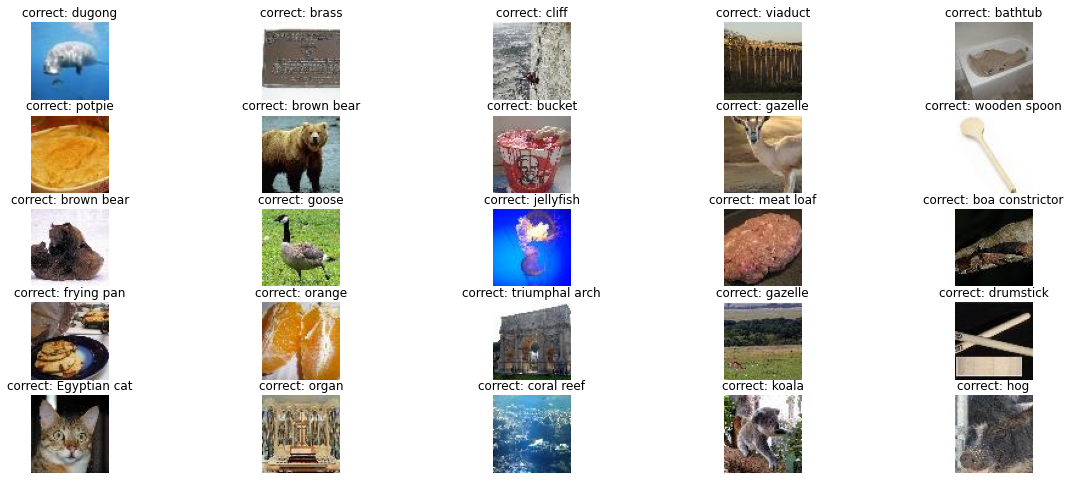

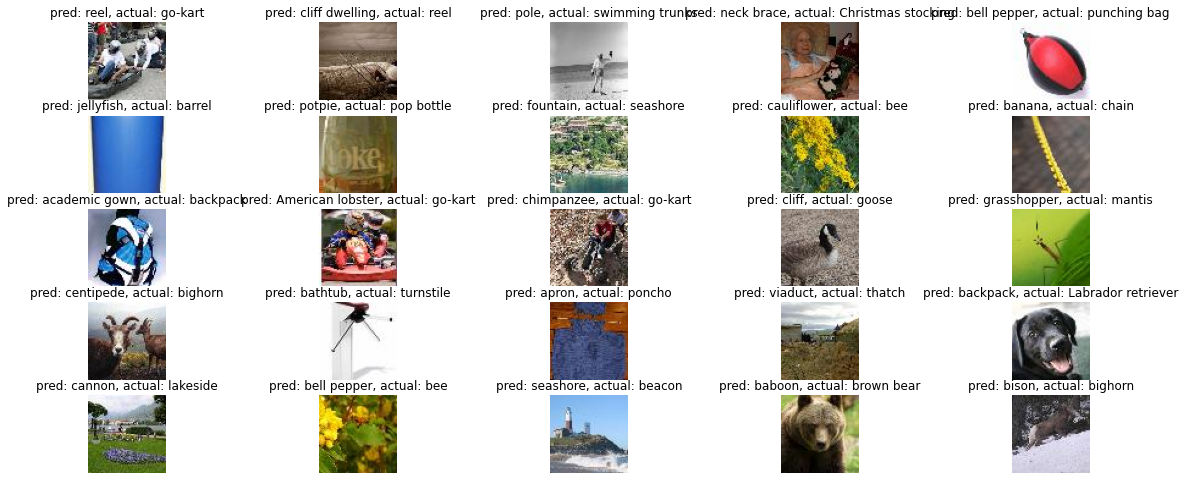

In [53]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.1" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


## TinyImageNet Questions

1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from CIFAR question 1.

To be honest, I had a fellowship application due on Monday and this HW is already 2 days late so I only tried one architecture with the standard settings buuuuuuut I'm hoping that I can explain my way through it so that I still get _mostly_ full credit. 

I thought about the problem (tiny images!) and realized that if I did very many operations with stride > 1 I would run out of meaningful pixels very, very quickly. This reminded me to think about what Joe had said in lecture and that people will try 3x3 convs followed by 1x1 convs and back to 3x3 AND THEN do a downsampling. So that's what I tried. 

I also thought that because the image was so small and I couldn't do any downsampling very many times I should try to "artificially" increase the depth of my network by giving it some residual connections. I remember learning that networks were getting too long and they had their gradients vanishing due to that. To circumvent that issue they started to implement residual connections. 

I couldn't really figure out quickly how to implement a true residual connection, but I implemented a forward residual connection to try to enhance the features of the images as I was processing them.

2. Were you able to use larger/deeper networks on TinyImageNet than you used on CIFAR and increase accuracy? If so, why? If not, why not?

My network is deeper than my CIFAR network, but that is because I tried the 3-1-3 convolution strategy to extract as much info as possible. I picked this up from a [blog](https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278) and modified it to see what I could get. I was optimistic, but for now it seems like I've capped out at 25% accuracy. I may update this section if I have time to run more epochs on the same network.

UPDATE: The network finished after 20 epochs and what we see is a severe overfitting of the training set. The test loss trends up significantly after epoch ~6. In order to fix this I could augment the data more, increase the complexity of my network, or introduce some more regularization (batch norm, high weight decay).

3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

Larger images: My first intuition is to always get the images to a reasonable size initially strictly for computational operations purposes. If the images are much larger than 256x256 I would resize them to that level first with a scaling operation. I don't think much information would be lost in terms of the gross level of object recognition/segmentation we are looking for. Once resized I think that a deeper network would be better for extraction and of course residual connections to keep the signal strong throughout the full length.

If we didn't want to resize the image an alternative could be to break the image up into subsections for processing. So a 512x512 image becomes 4 256x256 images. You could either run these as unique data samples (like we do already, just treat them as independent images) or possibly find a way to run them all in parallel on 4 different networks at the same time and then aggregate the results at the end. Kind of like do I think this quadrant of a picture belongs to a boat? If a majority of the segments vote yes then the image is a boat.

Smaller images: I have to think that a fully conncected network is the way to go for super small images. In this case  there would be high spatial correlation between pixels due to the low resolution. OR! I think you could scale up the image and then apply some kind of blurring effect. It would be kinda like when you can't quite make out something that you're looking at so you squint to see if your brain can process that better.

My Information Theory Answer to Network Accuracy Limits on Photo Resolution:
Shannon told us that _information = surprise!_ and in that regard low res or high res photos contain either a little or a lot of _surprise!_ If I were to pick a pixel and examine its neighborhood and they all looked the same that is low _surprise!_ If I examine another pixel and its neighborhood and there is a lot of variety that is a lot of _surprise!_ To us (and a network) neighborhoods with a lot of _surprise!_ are called **features**.

In this regard the accuracy of low-res images would seem to always be capped by some accuracy limit (in the test set, the training set could always saturate). There is less information equating to fewer features to extract and so a generalized decision cannot be made to an arbitrary threshold. A high-res photo would seem to offer near perfect accuracy. In fact if we had a network that could scan individual atoms in real life I bet we could get even better results. But high-res photos will always be limited by computational power, thus we are always battling to maximize efficiency of our high-res data sets.

# Turn-in

Download your `hw1.ipynb` and put it in your `uwnet` repository.